<a href="https://colab.research.google.com/github/OmkarKotwalProject/Dominos_Work/blob/main/Dominos_Work_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Useful Libraries and Loading the dataset

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import nltk
import re
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import sklearn.metrics as sm
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

!pip install pyspellchecker
!pip install Counter

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 2.7 MB 33.2 MB/s 
  Created wheel for Counter: filename=Counter-1.0.0-py3-none-any.whl size=5411 sha256=8a924938011ed653c10f905cbe1d2376e50eb880d0da4942f3f271dba7f098d3
  Stored in directory: /root/.cache/pip/wheels/f9/15/75/7a0462a00beb08e391f5da370ca409b56781d2501dba083fa3
Successfully built Counter
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)

Mounting the drive for accessing the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [4]:
cd /content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/Dominos Pizza 3k/

/content/drive/MyDrive/CUSTOMER_REVIEWS/ScrapedReviews/PROJECT SCRAPED REVIEWS/Dominos Pizza 3k


In [5]:
df = pd.read_excel('All_Reviews_DP.xlsx')

In [6]:
#Keeping the original as it is.
df_review=df 

THIS IS A BACKUP LOAD OF ORIGINAL DATAFRAME, ONLY USE IF something goes wrong and need to load the dataset again.

In [7]:
# #FOR EMPTYING THE DATAFRAME
# df_review.drop(columns=['Review','Sentiment'],inplace=True)

In [8]:
# #FOR RELOADING WITH ORIGINAL RAW DATA
# df = pd.read_excel('All_Reviews_DP.xlsx')
# df_review=df

BACKUP CODE END

In [9]:
df_review['Sentiment']=df_review['Sentiment'].astype(int)

In [10]:
print(df_review.head())
print(df_review.shape)

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

HOW MANY POSITIVE REVIEWS, HOW MANY NEGATIVE REVIEWS

In [11]:
print(df_review[df_review['Sentiment']==1].count())
print(df_review[df_review['Sentiment']==0].count())

Review       1543
Sentiment    1543
dtype: int64
Review       1203
Sentiment    1203
dtype: int64


In [12]:
#Checking if any null values
df_review[df_review.isna().any(axis=1)]

,Review,Sentiment


# PRE-PROCESSING!

1. Removing digits [\d]

In [13]:
df['Review']=df['Review'].replace('\d+','',regex=True)

2. Replacing special characters by empty space ‘ ‘ and dealing with any character that occurs more than twice: yummmmy => yummy

In [14]:
df_review['Review']=df_review['Review'].replace('\n', ' ',regex=True)
df_review['Review']=df_review['Review'].replace(('[^!|^.|^,|^;|^-|^@|^\w\s]'),"", regex = True)
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(',', ' ')
  sentence=sentence.replace('!', ' ')
  sentence=sentence.replace('.', ' ')
  sentence=sentence.replace(';', ' ')
  sentence=sentence.replace('-', ' ')
  sentence=sentence.replace('@', ' ')
  sentence=sentence.replace(')', ' ')
  sentence=sentence.replace('(', ' ')
  sentence=sentence.replace('{', ' ')
  sentence=sentence.replace('}', ' ')     

  sentence=re.sub(r'(.)\1+', r'\1\1',sentence)   # yummmyyy => yummyy,  '     '=>'  '  #This line will remove char which occures more than 2 times consecutively.
  df_review['Review'][i]=sentence

print(df_review.head(10))

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

3. REMOVING CHARACTERS WHICH ONLY OCCUR ONCE! ALSO REPLACING TWO CONSECUTIVE SPACES BY ONE

In [15]:
cnter=0
while(cnter<2):
  for i in range(len(df_review)):
    new_sentence=" "
    sentence=df_review['Review'][i]    #get the row i.e. sentence
    words=sentence.split()  #makes a list of the words in the sentence
    for word in words:      #check every words length and if it is less than 2, remove it
      if len(word)<2:
        words.remove(word)
    new_sentence=new_sentence.join(words) #Create a new sentence by joining all the words in the list with " " as a separator
    df_review['Review'][i]=new_sentence   #replace current row i.e. sentence by the new sentence
  cnter=cnter+1

In [16]:
print(df_review.head(5))

                                                                                                                                                                                                                                                              Review  \
0                                                                                                                                                                                                                                                       its too good   
1                                                                                                                                                                                                                                                     waste of money   
2                                                                                                                                                                                                               

4.FINDING MISSPELLED WORDS AND CORRECTING THEM!
Algorithm used for correcting words:

    Create a list of misspelled words found in the dataset.
    Create a list of correctly spelled words found in the dataset.
    Use similar() function of 'SequenceMatcher' for finding similarity between words from both lists. If it is greater than 0.8, create a dictionary (dict['misspelled word'=correctly spelled word).
    Now traverse the dataset, while checking a row, extract its misspelled words, check if misspelled word is in the dictionary, if it is then replace it with correctly spelled word.

In [17]:
#This creates a list of sets of misspelled words found in each row.
from spellchecker import SpellChecker
spell=SpellChecker()
mis_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i].split()
  mis_sent=spell.unknown(sentence)
  mis_list.append(mis_sent)
  if set() in mis_list:
    mis_list.remove(set())
print("first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]: ",mis_list[0:50])

first 50 row's Misspelled words but they are in [{misspelled words list from row 1},{misspelled words list from row 2}]:  [{'chocolava'}, {'recieved'}, {'zomato', 'rs'}, {'bcz'}, {'orderit'}, {'bt', 'rcv'}, {'coldrink', 'uneatable'}, {'zingy', 'flatt'}, {'mintues', 'gps', 'valle'}, {'delivary'}, {'zomato'}, {'chesse'}, {'cheeseburst', 'rs'}, {'cheeseburst', 'asnt'}, {'cheeseburst'}, {'pepar'}, {'hrs'}, {'zomato'}, {'divery'}, {'pneer'}, {'peproni'}, {'indi'}, {'cheeze'}, {'th'}, {'kanjus', 'paytm'}, {'sanitization'}, {'origano'}, {'jublfood'}, {'ppl'}, {'cheeze'}, {'dominoz'}, {'bbq'}, {'customization'}, {'plz'}, {'nilesh'}, {'dominoz'}, {'th'}, {'st'}, {'koparkhairane'}, {'choppings'}, {'nonveg'}, {'recwived', 'bcoz', 'nveg'}, {'bery', 'cheeze'}, {'pm'}, {'cheeseburst'}, {'makhani'}, {'choclate', 'deeped', 'panner'}, {'arenja'}, {'keema'}, {'hygeine'}]


In [18]:
#Creating a list of misspelled words. (Basically extracting each set element from the mis_list and putting it into mis_mis_list)

from collections import Counter
mis_mis_list=[]
for i in mis_list:
  for j in i:
    mis_mis_list.append(j.lower())   #just making the words lower before appending to mis_mis_list
   
print("first 50 Misspelled words:",mis_mis_list[0:50]) #LIST OF MISSPELLED WORDS   
print("Total misspelled words: ",len(mis_mis_list)) #Note: this list is not a 'unique mispelled words' list, it has repeated occurences of them.


#Finding common words and their occurrences in the mis_mis_list #Just a trial code for common words finder.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   
print(cmmn)

first 50 Misspelled words: ['chocolava', 'recieved', 'zomato', 'rs', 'bcz', 'orderit', 'bt', 'rcv', 'coldrink', 'uneatable', 'zingy', 'flatt', 'mintues', 'gps', 'valle', 'delivary', 'zomato', 'chesse', 'cheeseburst', 'rs', 'cheeseburst', 'asnt', 'cheeseburst', 'pepar', 'hrs', 'zomato', 'divery', 'pneer', 'peproni', 'indi', 'cheeze', 'th', 'kanjus', 'paytm', 'sanitization', 'origano', 'jublfood', 'ppl', 'cheeze', 'dominoz', 'bbq', 'customization', 'plz', 'nilesh', 'dominoz', 'th', 'st', 'koparkhairane', 'choppings', 'nonveg']
Total misspelled words:  1017
[('zomato', 65), ('pm', 25), ('rs', 21), ('aundh', 20), ('dominoz', 18), ('nonveg', 17), ('mexicana', 17), ('hr', 13), ('kandivali', 13), ('nd', 12), ('chocolava', 9), ('recieved', 9), ('cheeseburst', 9), ('hrs', 9), ('nigdi', 9), ('th', 8), ('bbq', 8), ('saudagar', 8), ('zingy', 7), ('plz', 7), ('makhani', 7), ('panner', 7), ('hv', 7), ('bt', 6), ('st', 6), ('cheeze', 5), ('km', 5), ('pls', 5), ('indi', 4), ('origano', 4), ('ppl', 4),

In [19]:
#REMOVING NAMES FROM THE LIST of misspelled words
names_list=['zomato','pm','rs','aundh','nonveg','mexicana','hr','kandivali','chocolava','nigdi',
            'cheeseburst','bbq','saudagar','zingy','makhani','paneer','periperi','tandoor']
for name in names_list:
  for j in range(len(mis_mis_list)):
    if name in mis_mis_list:
      mis_mis_list.remove(name)
print("Final Misspelled words list after removing names: (Showing only first 50) ",mis_mis_list[0:50]) #This is the list of misseplled words!



#Trial code for common words finder, again.
cnt=Counter(mis_mis_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)    

Final Misspelled words list after removing names: (Showing only first 50)  ['recieved', 'bcz', 'orderit', 'bt', 'rcv', 'coldrink', 'uneatable', 'flatt', 'mintues', 'gps', 'valle', 'delivary', 'chesse', 'asnt', 'pepar', 'hrs', 'divery', 'pneer', 'peproni', 'indi', 'cheeze', 'th', 'kanjus', 'paytm', 'sanitization', 'origano', 'jublfood', 'ppl', 'cheeze', 'dominoz', 'customization', 'plz', 'nilesh', 'dominoz', 'th', 'st', 'koparkhairane', 'choppings', 'recwived', 'bcoz', 'nveg', 'bery', 'cheeze', 'choclate', 'deeped', 'panner', 'arenja', 'keema', 'hygeine', 'fooding']
[('dominoz', 18), ('nd', 12), ('recieved', 9), ('hrs', 9), ('th', 8), ('plz', 7), ('panner', 7), ('hv', 7), ('bt', 6), ('st', 6), ('cheeze', 5), ('km', 5), ('pls', 5), ('indi', 4), ('origano', 4), ('ppl', 4), ('bcoz', 4), ('pizzaa', 4), ('yumm', 4), ('tacco', 4), ('makhni', 4), ('gst', 4), ('recieve', 4), ('covid', 4), ('bcz', 3), ('pizzaz', 3), ('ws', 3), ('piza', 3), ('pizaa', 3), ('rd', 3), ('tv', 3), ('margerita', 3), ('

Finding a list of correctly spelled words!

In [20]:
#first, just creating a list of words found in the dataset
correct_word_list=[]
for i in range(len(df_review)):
  sentence=df_review['Review'][i]
  words=sentence.split()
  for word in words:
    correct_word_list.append(word.lower())
print(correct_word_list[0:50])


['its', 'too', 'good', 'waste', 'of', 'money', 'pizza', 'was', 'yum', 'but', 'little', 'late', 'delivery', 'person', 'was', 'amazing', 'even', 'after', 'calling', 'personally', 'and', 'even', 'after', 'giving', 'special', 'instructions', 'received', 'very', 'cold', 'pizza', 'base', 'is', 'hard', 'and', 'it', 'tastes', 'stale', 'as', 'if', 'it', 'was', 'premade', 'thought', 'chicken', 'parcels', 'were', 'really', 'hot', 'and', 'fresh']


In [21]:
#We have to make both lists mis_mis_list and correct_words_list contain unique words, not repeated words or 'remove' won't work!
print("total of all words of misspelled word list:",len(mis_mis_list))
print("total of all words of correct word list+misspelled word list:",len(correct_word_list))
mis_mis_list=list(set(mis_mis_list))
correct_word_list=list(set(correct_word_list))
print("total of unique words of misspelled word list:",len(mis_mis_list))
print("total of unique words of correct word list+missplled word list:",len(correct_word_list))
print("total of unique words of names list:",len(names_list))

total of all words of misspelled word list: 761
total of all words of correct word list+misspelled word list: 60164
total of unique words of misspelled word list: 536
total of unique words of correct word list+missplled word list: 4136
total of unique words of names list: 18


In [22]:
names_list=['zomato','pm','rs','aundh','nonveg','mexicana','hr','kandivali','chocolava','nigdi',
            'cheeseburst','bbq','saudagar','zingy','makhani','paneer','periperi','tandoor']
cnt=0
#Removing misspelled words from correct_word_list, found in mis_mis_list
for w in mis_mis_list:
  if w in correct_word_list:
    correct_word_list.remove(w)

#Removing names from correct_word_list, found in names_list
for n in names_list:
  if n in correct_word_list:
    correct_word_list.remove(n) 
print("correct word list length after removing misspelled words and names:",len(correct_word_list))

correct word list length after removing misspelled words and names: 3582


In [23]:
#Checking similarity between words from correct_word_list and mis_mis_list, if its more than 0.8, 
#do dictionary[misspelled word]=correct word
#TAKES 1 MINUTE+
from difflib import SequenceMatcher       #Library used for checking similarity

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    #Function to check similarity!

dictionary={}
cnt=0
for cor_word in correct_word_list:
  for mis_word in mis_mis_list:
    ratio=similar(cor_word,mis_word)
    if(ratio>0.8):
      cnt=cnt+1
      dictionary[mis_word]=cor_word
      #print("Correct word:",cor_word,"    misspelled word:",mis_word,"      Ratio:",ratio)
print("This many words can be corrected: ",cnt)

This many words can be corrected:  355


In [24]:
#Replacing the misspelled words with correct words
#Takes almost 10 seconds
words_corrected_cnt=0
for i in range(len(df_review)):
  sentence=(df_review['Review'][i]).lower()
  print("before:",sentence)
  misspelled_words=spell.unknown(sentence.split())
  print("list:",misspelled_words)
  for misword in misspelled_words:
    if misword in dictionary:
      correct_word=dictionary[misword]
      print("misspelled word: ",misword,"     ","correct word:",correct_word)
      sentence=sentence.replace(misword,correct_word)
      words_corrected_cnt=words_corrected_cnt+1
  df_review['Review'][i]=sentence
  print("After:",sentence)

Streaming output truncated to the last 5000 lines.
before: never received the order and have asked for the money back to the source when speaking to kashif pathetic experience
list: {'kashif'}
After: never received the order and have asked for the money back to the source when speaking to kashif pathetic experience
before: but toppings are very less thats the only reason dont like it and also the cheese is less
list: set()
After: but toppings are very less thats the only reason dont like it and also the cheese is less
before: the order delivered so late that it got cold so didnt taste good overall bad experience
list: set()
After: the order delivered so late that it got cold so didnt taste good overall bad experience
before: its uncooked nonveg tacco is anyone even audit the orders before you push for delivery
list: {'nonveg', 'tacco'}
misspelled word:  tacco       correct word: taco
After: its uncooked nonveg taco is anyone even audit the orders before you push for delivery
before: or

In [25]:
#This many words were corrected and replaced
print(words_corrected_cnt)

342


5. Removing stopwords

In [26]:
print(df_review['Review'].head())

0                                                                                                                                                                                                                                                         its too good
1                                                                                                                                                                                                                                                       waste of money
2                                                                                                                                                                                                                                        pizza was yum but little late
3                                                                                                                                                                                                                  

In [27]:
from nltk.corpus import stopwords
sw=stopwords.words("english")
print(sw)
#Removing the words below from the stopword list as they do impact the outcome when doing sentiment analysis. 
sw.append('would')
sw.remove('not')
sw.remove('no')
sw.remove('don\'t')
sw.remove('didn\'t')
sw.remove('wouldn\'t')
sw.remove('wouldn')
sw.remove('won\'t')
sw.remove('didn')
sw.remove('don')
sw.remove('isn\'t')
sw.remove('isn')
sw.remove('couldn\'t')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Making 'Review' lower so I can remove stopwords

In [28]:
df_review['Review']=df_review['Review'].str.lower()

In [29]:
df_review['Review']=df_review['Review'].apply(lambda x:" ".join(x for x in str(x).split() if x not in sw))
print(df_review.head())

                                                                                                                                                                                           Review  \
0                                                                                                                                                                                            good   
1                                                                                                                                                                                     waste money   
2                                                                                                                                                                           pizza yum little late   
3                                                                                                                                                                         delivery person amazing   
4  even calling

In [30]:
#TOTAL WORDS AFTER REMOVING STOP WORDS!
p_list=[]
for i in range(len(df_review)):
  ent=df_review['Review'][i].split()
  p_list.append(ent)

word_list=[]
for element in p_list:
  for word in element:
    word_list.append(word)
print(len(word_list))

35989


EDA #2: COMMON WORDS And their frequency

For positive reviews

In [31]:
pos_reviews_list=[]
for rev in df_review[df_review['Sentiment']==1].Review:
  sent_list=rev.split()
  for w in sent_list:
    pos_reviews_list.append(w)


#Trial code for common words finder, again.
cnt=Counter(pos_reviews_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)

[('pizza', 819), ('good', 745), ('dominos', 445), ('service', 324), ('delivery', 301), ('place', 277), ('pizzas', 274), ('time', 236), ('cheese', 227), ('taste', 205), ('nice', 180), ('great', 161), ('food', 157), ('best', 151), ('always', 140), ('not', 133), ('chicken', 133), ('also', 130), ('outlet', 130), ('one', 129), ('order', 125), ('love', 119), ('awesome', 115), ('ordered', 113), ('like', 102), ('burst', 102), ('really', 94), ('staff', 93), ('hot', 92), ('garlic', 92), ('delicious', 87), ('veg', 86), ('quality', 83), ('bread', 83), ('well', 82), ('yummy', 80), ('amazing', 75), ('fast', 73), ('no', 73), ('try', 72), ('quick', 72), ('tasty', 70), ('home', 69), ('paneer', 68), ('better', 64), ('delivered', 62), ('overall', 60), ('crust', 59), ('experience', 59), ('toppings', 58), ('small', 55), ('must', 51), ('cake', 50), ('new', 50), ('cheesy', 49), ('excellent', 48), ('tried', 48), ('even', 47), ('lava', 45), ('fresh', 45), ('friends', 45), ('get', 45), ('ambience', 44), ('go', 

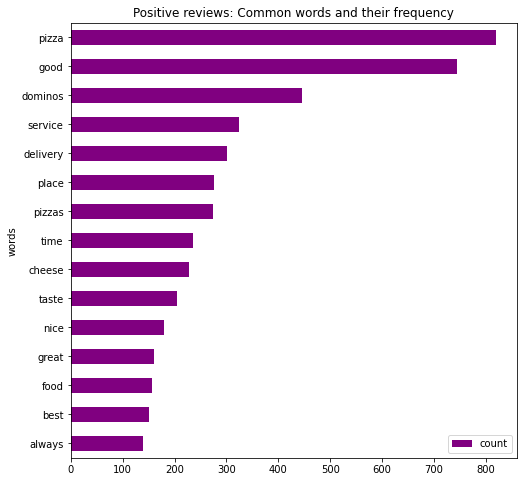

In [32]:
#cnt=Counter(df_review[df_review['Sentiment']==1].Review)
cnt=Counter(pos_reviews_list)
pos_common_words=pd.DataFrame(cnt.most_common(15), columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Positive reviews: Common words and their frequency")
plt.show()

In [33]:
#Creating bi-grams
bigram_measures=nltk.collocations.BigramAssocMeasures()

finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df_review[df_review['Sentiment']==1].Review])

In [34]:
finder.apply_freq_filter(25)
bigram_scores=finder.score_ngrams(bigram_measures.pmi)
print(len(bigram_scores))

19


In [35]:
bigram_scores[0][0]
cnt_list=[]
for gram in bigram_scores:
  x = '_'.join(gram[0])
  cnt_list.append((x,gram[1]))
print(cnt_list[0:10])

[('choco_lava', 8.562206074681752), ('lava_cake', 8.27319260226712), ('peppy_paneer', 7.921508440232547), ('garlic_bread', 7.491191678019877), ('must_try', 7.406086872764467), ('cheese_burst', 6.276710389780735), ('delivery_boy', 5.8342452937767515), ('home_delivery', 5.245094996092162), ('nice_place', 3.362734034606678), ('dominos_outlet', 3.148299958103326)]


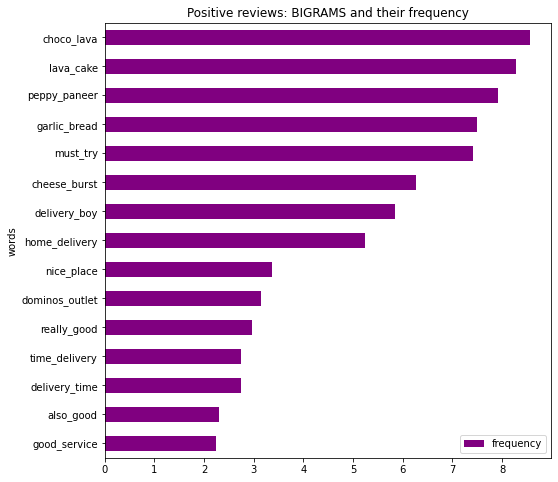

In [36]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(cnt_list)
pos_common_words=pd.DataFrame(cnt_list[0:15], columns=['words','frequency'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='frequency').plot.barh(x='words',y='frequency',ax=ax,color='purple')
ax.set_title("Positive reviews: BIGRAMS and their frequency")
plt.show()

For Negative Reviews

In [37]:
neg_reviews_list=[]
for rev in df_review[df_review['Sentiment']==0].Review:
  sent_list=rev.split()
  for w in sent_list:
    neg_reviews_list.append(w)


#Trial code for common words finder, again.
cnt=Counter(neg_reviews_list)
cmmn=cnt.most_common(100)   #Finding common words and their occurrences in the mis_mis_list     
print(cmmn)

[('pizza', 668), ('not', 651), ('order', 475), ('dominos', 313), ('delivery', 286), ('cheese', 267), ('time', 212), ('ordered', 202), ('service', 193), ('no', 186), ('good', 183), ('late', 152), ('delivered', 150), ('bad', 146), ('worst', 133), ('food', 113), ('also', 112), ('experience', 112), ('even', 111), ('received', 101), ('one', 101), ('quality', 99), ('taste', 98), ('outlet', 98), ('got', 96), ('place', 96), ('pizzas', 94), ('burst', 92), ('dont', 91), ('didnt', 90), ('cold', 88), ('staff', 88), ('like', 86), ('get', 83), ('less', 78), ('zomato', 77), ('deliver', 75), ('never', 68), ('bread', 66), ('hour', 64), ('call', 62), ('mins', 62), ('disappointed', 60), ('pathetic', 58), ('veg', 57), ('ever', 55), ('customer', 53), ('garlic', 52), ('money', 51), ('chicken', 49), ('home', 49), ('really', 48), ('times', 48), ('much', 46), ('toppings', 45), ('refund', 45), ('poor', 44), ('properly', 44), ('please', 43), ('hot', 42), ('base', 41), ('minutes', 41), ('took', 40), ('online', 39

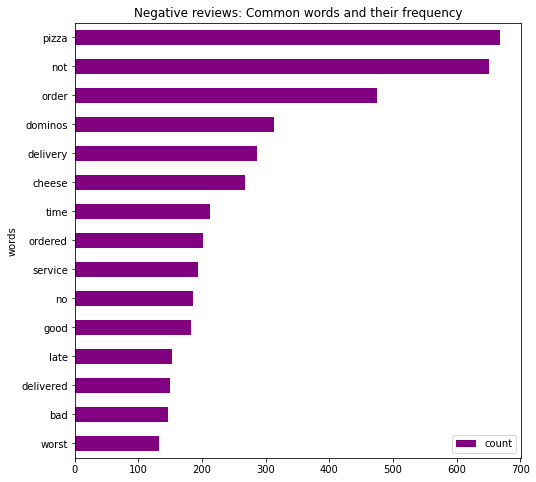

In [38]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(neg_reviews_list)
pos_common_words=pd.DataFrame(cnt.most_common(15), columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Negative reviews: Common words and their frequency")
plt.show()

In [39]:
#Creating bi-grams
bigram_measures=nltk.collocations.BigramAssocMeasures()

finder=nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df_review[df_review['Sentiment']==0].Review])

In [40]:
finder.apply_freq_filter(25)
bigram_scores=finder.score_ngrams(bigram_measures.pmi)
#print('_'.join(bigram_scores[0][0]))
print(len(bigram_scores))

16


In [41]:
bigram_scores[0][0]
cnt_list=[]
for gram in bigram_scores:
  x = '_'.join(gram[0])
  cnt_list.append((x,gram[1]))
print(cnt_list[0:10])

[('garlic_bread', 7.949224726928794), ('cheese_burst', 5.951102930664714), ('delivery_boy', 5.659718109733809), ('bad_experience', 5.359844096213143), ('home_delivery', 5.334514882813586), ('worst_experience', 5.0013462083118565), ('late_delivery', 4.127561968187305), ('worst_service', 4.1052127807126375), ('received_order', 3.603494997095531), ('not_good', 3.39662961176219)]


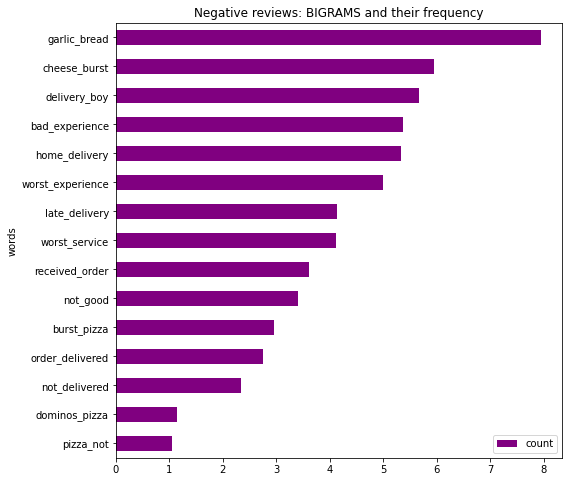

In [42]:
#cnt=Counter(df_review[df_review['Sentiment']==0].Review)
cnt=Counter(cnt_list)
pos_common_words=pd.DataFrame(cnt_list[0:15], columns=['words','count'])
pos_common_words.head()

fig,ax=plt.subplots(figsize=(8,8))
pos_common_words.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color='purple')
ax.set_title("Negative reviews: BIGRAMS and their frequency")
plt.show()

6. Tokenization

In [43]:
#Tokenization done to apply Lemmatization
w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
lemmatizer=nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]

df_review['Review']=df_review.Review.apply(lemmatize_text)
print(df_review.head())

                                                                                                                                                                                                          Review  \
0                                                                                                                                                                                                         [good]   
1                                                                                                                                                                                                 [waste, money]   
2                                                                                                                                                                                     [pizza, yum, little, late]   
3                                                                                                                                                       

From tokenized to normal

In [44]:
df_review['NewReview'] = df_review['Review'].apply(lambda s1: ' '.join(map(str,s1)) )

print(df_review['NewReview'].head())

0                                                                                                                                                                                  good
1                                                                                                                                                                           waste money
2                                                                                                                                                                 pizza yum little late
3                                                                                                                                                                 delivery person amaze
4    even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza
Name: NewReview, dtype: object


In [45]:
df_review['NewReview']=df_review['NewReview'].str.lower()
df_review.head()

,Review,Sentiment,NewReview
0,[good],1,good
1,"[waste, money]",0,waste money
2,"[pizza, yum, little, late]",1,pizza yum little late
3,"[delivery, person, amaze]",1,delivery person amaze
4,"[even, call, personally, even, give, special, instructions, receive, cold, pizza, base, hard, taste, stale, premade, think, chicken, parcel, really, hot, fresh, proper, quantity, really, disappoint, pizza]",0,even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza


# Sentiment Analysis

In [46]:
print("The number of samples in the dataset!")
pos_percent=(len(df_review[df_review['Sentiment']==1])/len(df_review)*100)
print("Positive reviews percentage: ",round(pos_percent,2),"%")
neg_percent=(len(df_review[df_review['Sentiment']==0])/len(df_review)*100)
print("Negative reviews percentage: ",round(neg_percent,2),"%")
print("Positive reviews: ",len(df_review[df_review['Sentiment']==1]))
print("Negative reviews: ",len(df_review[df_review['Sentiment']==0]))

The number of samples in the dataset!
Positive reviews percentage:  56.19 %
Negative reviews percentage:  43.81 %
Positive reviews:  1543
Negative reviews:  1203


Train-test split starts here!

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
train_data,test_data=train_test_split(df_review,test_size=0.2,random_state=50)  #keep random_state=50 for higher precision and recall of 0 class when using SVM
#train_data,test_data=train_test_split(new_df_review,test_size=0.4,random_state=25)

In [49]:
print(df_review.shape)
print('test_data(Positive):',test_data[test_data['Sentiment']==1].count())
print('test_data(Negative):',test_data[test_data['Sentiment']==0].count())

print("train_data (Positive):",train_data[train_data['Sentiment']==1].count())
print('train_data (Negative):',train_data[train_data['Sentiment']==0].count())

(2746, 3)
test_data(Positive): Review       311
Sentiment    311
NewReview    311
dtype: int64
test_data(Negative): Review       239
Sentiment    239
NewReview    239
dtype: int64
train_data (Positive): Review       1232
Sentiment    1232
NewReview    1232
dtype: int64
train_data (Negative): Review       964
Sentiment    964
NewReview    964
dtype: int64


In [50]:
X_train=train_data['NewReview']
y_train=train_data['Sentiment']
X_test=test_data['NewReview']
y_test=test_data['Sentiment']

In [51]:
print(X_train.head())
print(X_test.head())

17                                                                                                                                                                                                                      delivery charge high even zomato pro members around rs dominos outlet literally next door house
1263                                                                                                                                          dominos dominos outlet locate thakur college thakur village dominos time favourite ambience outdoor indoor staff friendly pizza tasty yummy think one best outlet dominos
473     dominos best place crave pizza like domino pizza hut cheese burst die soo freak cheesy new addition menu burger pizza look like burger taste like pizza try burger pizza today superb soo cheesy hot soft lot veggies chicken piece new favourite guy wait goo hog youll definitely love cant miss piece heaven
2496                                                            

7. Vectorizer

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
train_review_tfidf=train_vectorizer.fit_transform(X_train)

In [54]:
print(train_review_tfidf.shape)
type(train_review_tfidf)

(2196, 2786)


scipy.sparse.csr.csr_matrix

a. LOGISTIC REGRESSION

In [55]:
log_model=LogisticRegression().fit(train_review_tfidf, y_train)

In [56]:
#USE THIS WHEN TESTING ON SPLIT TEST DATA
nr=train_vectorizer.transform(X_test)
log_model.predict(nr)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,

In [57]:
predicted=log_model.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

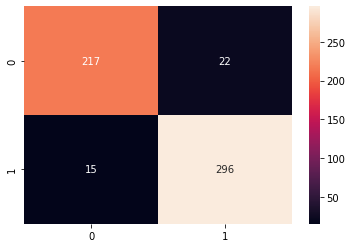

In [58]:
import seaborn as sns
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [59]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       239
           1       0.93      0.95      0.94       311

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



b. SVM

In [60]:
from sklearn.svm import SVC
svclassifier=SVC(kernel='rbf',C=10,gamma=1)
svclassifier.fit(train_review_tfidf,y_train)

SVC(C=10, gamma=1)

In [61]:
nr=train_vectorizer.transform(X_test)
svclassifier.predict(nr)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,

In [62]:
predicted=svclassifier.predict(nr)
p=pd.DataFrame(predicted)
actual=y_test

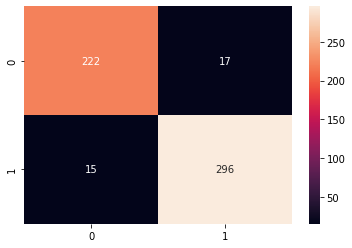

In [63]:
cf_matrix=sm.confusion_matrix(actual,p)
sns.heatmap(cf_matrix,annot=True,fmt='g')

In [64]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       239
           1       0.95      0.95      0.95       311

    accuracy                           0.94       550
   macro avg       0.94      0.94      0.94       550
weighted avg       0.94      0.94      0.94       550



# Topic Modelling

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

In [66]:
corpus_bert=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview)
corpus_lda=pd.DataFrame(df_review[df_review['Sentiment']==0].NewReview)


In [67]:
corpus_bert=corpus_bert.reset_index()
corpus_lda=corpus_lda.reset_index()

In [68]:
print(corpus_bert.head())

   index  \
0      1   
1      4   
2      6   
3      9   
4     10   

                                                                                                                                                                            NewReview  
0                                                                                                                                                                         waste money  
1  even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza  
2                                                                                                extremely less toppings spend much dominos kind toppings provide really poor service  
3                                                                                                                                                               box not seal properly  
4      

In [ ]:
!pip install pyLDAvis

In [70]:
train_vectorizer=TfidfVectorizer(use_idf=True,lowercase=True,strip_accents='ascii')
tfidf_=train_vectorizer.fit_transform(corpus_lda.NewReview)

num_components=10
lda=LatentDirichletAllocation(n_components=num_components,max_iter=100)
lda_tfidf=lda.fit(tfidf_)

In [71]:
#pyLDAvis for tfidf 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_tfidf,tfidf_,train_vectorizer)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.270136  0.117909       1        1  42.828151
7      0.189572 -0.159684       2        1  15.934197
2     -0.067568 -0.007146       3        1   6.177630
3     -0.040095  0.041135       4        1   5.658681
0     -0.059693  0.003097       5        1   5.479215
6     -0.042676  0.002692       6        1   5.273823
5     -0.060750  0.009220       7        1   5.261322
4     -0.062310 -0.010807       8        1   4.995945
8     -0.066083  0.001816       9        1   4.435324
9     -0.060532  0.001767      10        1   3.955712, topic_info=                 Term       Freq      Total Category  logprob  loglift
1026             late  42.000000  42.000000  Default  30.0000  30.0000
487          delivery  39.000000  39.000000  Default  29.0000  29.0000
485           deliver  33.000000  33.000000  Default  28.0000  28.0000
1301            order  53.000000  53.000000  Default  27.0000  27.0000
291            cheese  31.000000  31.000000  Default  26.0000  26.0000
1038             less  13.000000  13.000000  Default  25.0000  25.0000
1526          receive  19.000000  19.000000  Default  24.0000  24.0000
1398            pizza  53.000000  53.000000  Default  23.0000  23.0000
1912             time  28.000000  28.000000  Default  22.0000  22.0000
1250              not  59.000000  59.000000  Default  21.0000  21.0000
884               hot   9.000000   9.000000  Default  20.0000  20.0000
2123            wrong   5.000000   5.000000  Default  19.0000  19.0000
340              cold  18.000000  18.000000  Default  18.0000  18.0000
2027              veg   6.000000   6.000000  Default  17.0000  17.0000
791              good  28.000000  28.000000  Default  16.0000  16.0000
1306          oregano   5.000000   5.000000  Default  15.0000  15.0000
481             delay  10.000000  10.000000  Default  14.0000  14.0000
243             burst  13.000000  13.000000  Default  13.0000  13.0000
776               get  21.000000  21.000000  Default  12.0000  12.0000
1931              top   6.000000   6.000000  Default  11.0000  11.0000
1154              min   7.000000   7.000000  Default  10.0000  10.0000
2135              yet   3.000000   3.000000  Default   9.0000   9.0000
886              hour  10.000000  10.000000  Default   8.0000   8.0000
1859            taste  18.000000  18.000000  Default   7.0000   7.0000
181            better   6.000000   6.000000  Default   6.0000   6.0000
1159             mins  10.000000  10.000000  Default   5.0000   5.0000
299           chicken   7.000000   7.000000  Default   4.0000   4.0000
1243              non   3.000000   3.000000  Default   3.0000   3.0000
2115            worst  21.000000  21.000000  Default   2.0000   2.0000
251              call  12.000000  12.000000  Default   1.0000   1.0000
642        experience  16.897752  17.396607   Topic1  -4.5349   0.8189
1488          quality  14.843863  15.342737   Topic1  -4.6645   0.8149
791              good  27.829774  28.868618   Topic1  -4.0360   0.8113
1048             like  11.750032  12.248903   Topic1  -4.8982   0.8064
2115            worst  20.968886  21.887851   Topic1  -4.3191   0.8051
1314           outlet  10.662673  11.161557   Topic1  -4.9954   0.8022
220             bread   9.205084   9.703940   Topic1  -5.1423   0.7952
1859            taste  17.600033  18.560417   Topic1  -4.4942   0.7948
1180            money   9.100526   9.599378   Topic1  -5.1538   0.7946
766            garlic   7.655426   8.154279   Topic1  -5.3267   0.7848
617              ever   8.365594   8.944661   Topic1  -5.2380   0.7810
158              base   7.189979   7.688831   Topic1  -5.3894   0.7809
1197             much   8.058492   8.682112   Topic1  -5.2754   0.7734
880          horrible   5.985276   6.484140   Topic1  -5.5728   0.7679
1734            small   5.824327   6.323196   Topic1  -5.6001   0.7658
1215             need   5.821239   6.320130

Using BERTopic

In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
!pip install bertopic[visualization] --quiet

     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 88 kB 5.6 MB/s 
     |████████████████████████████████| 5.2 MB 27.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.2 MB 34.2 MB/s 
     |████████████████████████████████| 1.2 MB 22.8 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 636 kB 22.7 MB/s 
     |████████████████████████████████| 6.6 MB 44.7 MB/s 
     |████████████████████████████████| 1.1 MB 40.2 MB/s 


In [74]:
from bertopic import BERTopic

In [75]:
corpus=list(corpus_bert.NewReview)
print(corpus[0:5])

['waste money', 'even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza', 'extremely less toppings spend much dominos kind toppings provide really poor service', 'box not seal properly', 'order deliver lately pizza cold garlic bread also cold didnt enjoy']


In [76]:
corpus=list(corpus_bert.NewReview)
print(corpus[0:5])

['waste money', 'even call personally even give special instructions receive cold pizza base hard taste stale premade think chicken parcel really hot fresh proper quantity really disappoint pizza', 'extremely less toppings spend much dominos kind toppings provide really poor service', 'box not seal properly', 'order deliver lately pizza cold garlic bread also cold didnt enjoy']


In [86]:
bert_model=BERTopic(language="english", nr_topics=25)

In [87]:
topics,probs=bert_model.fit_transform(corpus)

In [88]:
#Getting most frequent topics
bert_model.get_topic_freq()

,Topic,Count
0,-1,402
1,0,122
2,1,56
3,2,53
4,3,48
5,4,42
6,5,37
7,6,31
8,7,31
9,8,29


In [89]:
bert_model.get_topics()

{-1: [('pizza', 0.025635148496052116),
  ('order', 0.025187058782786525),
  ('not', 0.02090787171107984),
  ('cheese', 0.020387068729302307),
  ('service', 0.020007521110999307),
  ('dominos', 0.018489936734705885),
  ('time', 0.018126848252657687),
  ('call', 0.016844451968041078),
  ('get', 0.016169243620438572),
  ('delivery', 0.01594932840025093)],
 0: [('dominos', 0.04414381458157468),
  ('outlet', 0.03301437380838162),
  ('good', 0.03106598687206377),
  ('not', 0.027665644289573837),
  ('pizza', 0.025881142247276164),
  ('taste', 0.02581532367295471),
  ('work', 0.025645778055586328),
  ('table', 0.02401636490162175),
  ('pizzas', 0.023997542896553738),
  ('place', 0.02323983320502475)],
 1: [('food', 0.16777213554143294),
  ('good', 0.06474231301607403),
  ('quality', 0.06459342059667264),
  ('not', 0.055960149791689055),
  ('taste', 0.054248127944603264),
  ('late', 0.04878914363995011),
  ('deliver', 0.04495563608496296),
  ('bad', 0.03617288281203853),
  ('come', 0.0352282082

Visualization of BERTopic!

In [90]:
import warnings
warnings.filterwarnings("ignore")

In [91]:
topic_list=[i for i in range(len(bert_model.get_topics())-1)]
print(topic_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [92]:
bert_model.visualize_barchart(topic_list, n_words=10, height=300)

If you want to see the complaints (reviews) wrt to the topic

In [93]:
df_tpc = pd.DataFrame({'topic': topics, 'document': corpus})

In [94]:
df_tpc[df_tpc['topic']==26].document

Series([], Name: document, dtype: object)